# Working with Higher Level Imaging Data in HTAN: Multiplexed Ion Beam Imaging (MIBI) Centroid Visualization


```
Title:   Working with Higher Level Imaging Data: MIBI Centroid Visualization
Author:  Dar'ya Pozhidayeva (dpozhida@systemsbiology.org)
Created: 2023-10-20
Updated: 2025-6-9
Purpose: Pull high-level HTAN imaging data from Synapse and Google BigQuery
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Analyzing_HTAN_MIBI_Imaging_Data.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )


### 1.1 Goal

This notebook will demonstrate how higher level HTAN imaging data can be pulled from [Synapse](https://www.synapse.org/) and [Google BigQuery](https://cloud.google.com/bigquery/pricing?utm_source=google&utm_medium=cpc&utm_campaign=na-US-all-en-dr-bkws-all-all-trial-b-dr-1605212&utm_content=text-ad-none-any-DEV_c-CRE_665665924753-ADGP_Hybrid%20%7C%20BKWS%20-%20MIX%20%7C%20Txt_BigQuery%20Pricing-KWID_43700077225652908-kwd-388453330994&utm_term=KW_bigquery%20cost-ST_bigquery%20cost&gclid=CjwKCAjwvrOpBhBdEiwAR58-3NcMSxrjJZYGofXntyXbritBvnykgqshKwhwmHeAvZd0AtSedM8nEBoChaAQAvD_BwE&gclsrc=aw.ds) for analysis or visualization.


The time for completing this notebook should be about 15 minutes.

### 1.2 Inputs, Outputs, & Data

Inputs for this analysis consist of HTAN Multiplexed Ion Beam Imaging (MIBI) Imaging data (Level 3 Segmentation and Level 4, gene summarized).

In HTAN, Level 3 segmentation images provide the information for the pixel mask surrounding each cell. Level 4 Imaging data consists of an object-by-feature table (typically cell-by-marker) generated from the segmentation mask and image.


The data was derived in October 2023 from a CSV file (Imaging Level 4; Synapse ID: syn52126197) and segmentation image (Imaging Level 3; Synapse ID: syn51524889) submitted by the Duke HTAN Center. Full details of data acquisition and processing can be found in the manuscript:

- [Risom T, et al., Transition to invasive breast cancer is associated with progressive changes in the structure and composition of tumor stroma. Cell.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8792442/)

As an overview, the following methods were pulled from the manuscript's methods section:

Imaging was performed using a MIBI-TOF instrument (IonPath) with a Hyperion ion source. Xe+ primary ions were used to sequentially sputter pixels for a given field of view (FOV). The following imaging parameters were used: acquisition setting: 80 kHz; field size: 500×500 μm, 1024 × 1024 pixels; dwell time: 5 ms; median gun current on tissue: 1.45 nA Xe+; ion dose: 4.23 nAmp h/mm2 for 500×500 μm FOVs. For each FOV, Mass-spec pixel data were then converted to TIFF images where the counts for each mass were taken between the ‘Start’ and ‘Stop’ values defined in Table S2.

### 1.3 Notes
The queries and results in this notebook correspond to ISB-CGC HTAN Release 6.0. However, if no modification to the dataset occurred (additions or removals) since a previous release, the existing version remains valid. As a result, some tables retain names ending in `r4`, indicating they have not been updated since Release 4.0, but are still current for Release 6.0.

To choose a different release, edit the BigQuery table names in this notebook by replacing the string `r4` with a selected numbered release, e.g., `r2`. To get results for the most current data release, replace:
- `r4` with `current`
- `HTAN_versioned` with `HTAN`

# 2. Environment & Module Setup

In [1]:
# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
from skimage.measure import regionprops_table
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

If you are using Google Colab, run the code block below to authenticate:

In [ ]:
from google.colab import auth
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [ ]:
# env GOOGLE_APPLICATION_CREDENTIALS='<path to key>'

## 3.2 Initializing the Google BigQuery client

In [2]:
# Import the Google BigQuery client
from google.cloud import bigquery

# Set the Google project that will be billed for this notebook's computations
# Replace <my-project> with your BigQuery Project ID
google_project = '<my-project>'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

# 4. Pull Data from Google BigQuery

Once authentication and project setup is complete, we can work with HTAN data available in BigQuery.

To do this, we create a SQL query to access the level 4 imaging MIBI data.
This query will pull the matrix for all normalized expression across **all cells and patients in the data set.**

In [3]:
# We'll use the following query to fetch the Level 4 Imaging Counts from Google Cloud BigQuery
mibi_l4 = client.query("""
SELECT * FROM `isb-cgc-bq.HTAN_versioned.imaging_level4_Duke_mibi_r4`
    """).result().to_dataframe()

In [4]:
# Let's check
mibi_l4

,Point_Num,HTAN_Parent_Data_File_ID,event,CohortNumber,cell_size,COLI,CD14,P63,Background,pS6,...,Neighbor_dist_NEUT,Neighbor_dist_IMMUNEOTHER,K10_cluster,duct_edge_mask,duct_mid_mask,duct_core_mask,Source_filename,Source_entityId,HTAN_Center,HTAN_Biospecimen_ID
0,2203,HTA6_1135_316,70004,3,0.810749,0.000000,0.000000,0.000000,0.575112,0.161122,...,0.0,0.0,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1135_1
1,2203,HTA6_1135_316,70005,3,0.602907,0.000000,0.000000,0.000000,0.553297,0.000000,...,0.0,0.0,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1135_1
2,2203,HTA6_1135_316,70010,3,0.574645,0.000000,0.000000,0.000000,0.553130,0.000000,...,0.0,0.0,7,0,1,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1135_1
3,2203,HTA6_1135_316,70019,3,0.855456,0.000000,0.000000,0.000000,0.609975,0.265083,...,0.0,0.0,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1135_1
4,2203,HTA6_1135_316,70037,3,0.747776,0.000000,0.000000,0.000000,0.635252,0.687813,...,0.0,0.0,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1135_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69667,4142,HTA6_EXT7_45,76781,108,0.700582,0.380503,0.659841,0.881103,0.785324,0.000000,...,0.0,0.0,6,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_EXT7_1
69668,4142,HTA6_EXT7_45,76849,108,0.724548,0.060629,0.791786,0.996175,0.724716,0.277263,...,0.0,0.0,3,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_EXT7_1
69669,4142,HTA6_EXT7_45,76875,108,0.609674,0.000000,0.468906,0.656449,0.825026,0.454372,...,0.0,0.0,7,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_EXT7_1
69670,4142,HTA6_EXT7_45,76909,108,0.690007,0.000000,0.749803,0.898651,0.800302,0.000000,...,0.0,0.0,8,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_EXT7_1


We can see that the full data set comprises of 69672 rows (cells) and 141 columns (features).

# 5. Reproducing figures from the Publication

To showcase data use, this notebook will reproduce some figures from the [publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8792442).

Specifically, we will focus on [Figures 2C, 2D, and 2E](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8792442/figure/F2/) shown below.

<a href="https://www.researchgate.net/figure/A-single-cell-phenotypic-atlas-of-DCIS-epithelium-and-its-microenvironment-A-Depiction_fig2_357978879"><img src="https://www.researchgate.net/publication/357978879/figure/fig2/AS:1117627636289540@1643474601357/A-single-cell-phenotypic-atlas-of-DCIS-epithelium-and-its-microenvironment-A-Depiction.jpg" alt="A single-cell phenotypic atlas of DCIS epithelium and its microenvironment (A) Depiction of the parallel tissue analysis methods used in this study, including H&E staining, laser-capture microdissection (LCM) of stroma and epithelium with RNA-seq, and MIBI-TOF with an overview of the MIBI-TOF workflow. (B) Markers used in the MIBI-TOF panel, grouped by target cell type or protein class. (C) Cell lineage assignments based on normalized expression of lineage markers (heatmap columns). Rows are ordered by absolute abundance (bar plot, left), while columns are hierarchically clustered (euclidean distance, average linkage). Myoep, myoepithelial cell; Mono, monocyte; Endo, endothelial cell; APC, antigen-presenting cell; Macs, macrophages;"/></a>

## 5.1 The Heatmap (2C)

In the text, Figure 2C is described as the following:

(C) Cell lineage assignments based on normalized expression of lineage markers (heatmap columns). Rows are ordered by absolute abundance (bar plot, left), while columns are hierarchically clustered (euclidean distance, average linkage). Myoep, myoepithelial cell; Mono, monocyte; Endo, endothelial cell; APC, antigen-presenting cell; Macs, macrophages; ImmOther, immune other; MonoDC, monocyte-derived dendritic cell; dnT, double-negative T cell; DC, dendritic cell.

To recreate this figure, we will need two items; a clustered heatmap and a barplot of cell counts across cell sublineages.

In [5]:
# Select the features for the heatmap
heat_features = mibi_l4[['sublineage']]
# Select the columns with marker expression
heat_exp= mibi_l4.iloc[:,5:58]
# Create a dataframe with mean expression
heat_map = heat_features.join(heat_exp)
# Calculate the mean, normalized expression of markers for each sub lineage.
avg_heat = heat_map.groupby('sublineage').mean()

In [6]:
# Subset the cell counts to be used later
avg_heat['cell_counts'] = heat_map.groupby('sublineage').count()['CD14']

[]

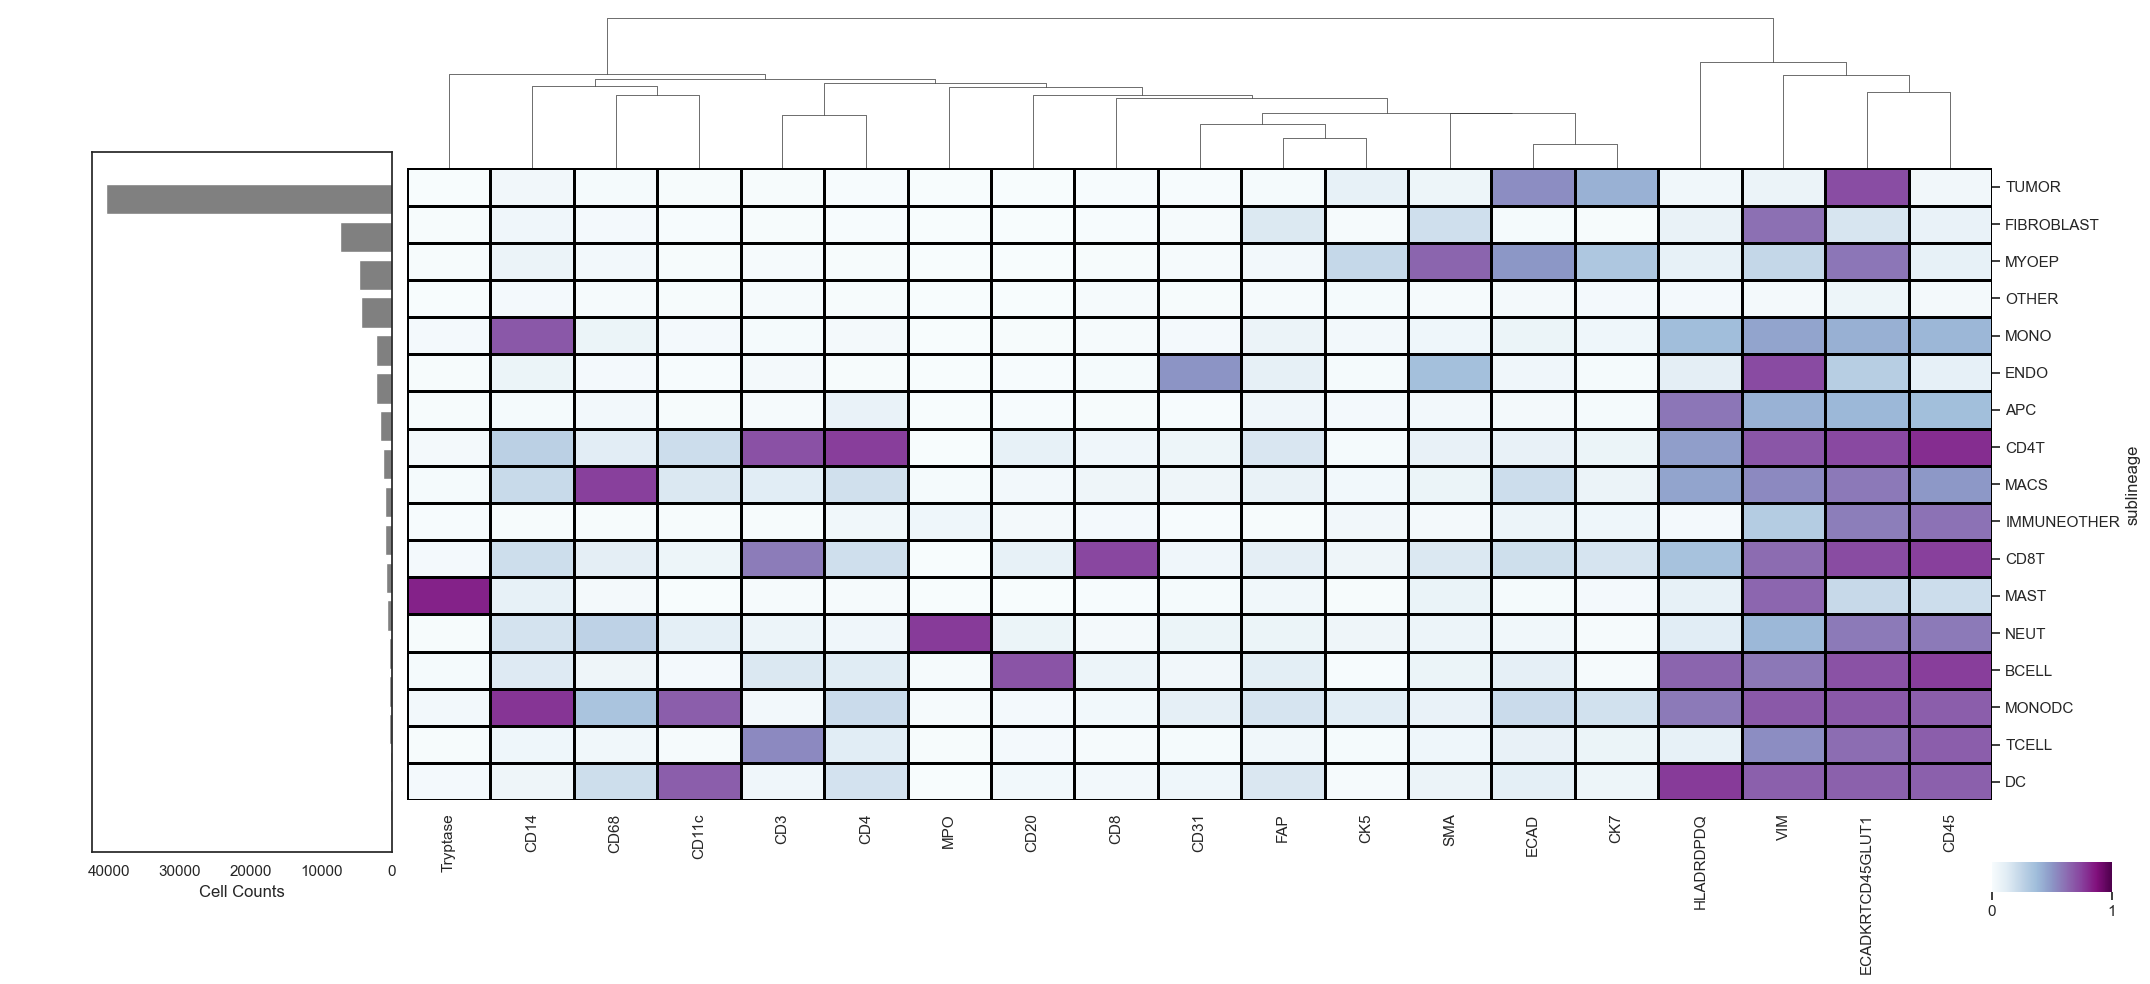

In [23]:
# Sort all values by cell counts
avg_heat=avg_heat.sort_values(by=['cell_counts'], ascending=False)

#Subset the relevant markers shown in Figure 2C:
figure_2c = avg_heat[['ECADKRTCD45GLUT1', 'ECAD', 'CK7', 'FAP', 'CK5', 'CD31',
                         'SMA', 'CD8', 'CD68', 'CD20', 'MPO', 'CD3', 'CD4', 'Tryptase',
                         'CD14', 'CD11c', 'VIM','CD45', 'HLADRDPDQ']]

# Set plotting parameters and call clustermap
kws = dict(cbar_kws=dict(ticks=[0, 1], orientation='horizontal'))
g = sns.clustermap(figure_2c, annot=False, row_cluster=False, vmin=0,
                   vmax=1, **kws, cmap="BuPu", linewidth=0.8, linecolor='black')
g.fig.subplots_adjust(right=2)
g.ax_cbar.set_position((2, 0.1, 0.12, 0.03))

# Set plotting parameters and call barplot
ax = g.fig.add_axes([0.1, 0.14, 0.3, 0.7])
sns.barplot(avg_heat, x="cell_counts", y=avg_heat.axes[0], color='gray').invert_xaxis()
ax.set(yticklabels=[])
ax.set(xlabel='Cell Counts', ylabel=None)
plt.plot()

*Note, that the Normalized expression value of the combination of markers ECAD, PanKRT, GLUT1, CD44, and CD45 is shown as ECADKRTCD45GLUT1 above.*

Here, we can see that the expression of markers across these sublineages lines up with the figure in the publication. For example, Tryptase has the highest expression in mast cells and so on. Minor differences can be seen, e.g in columns used and ordering.

## 5.2 Selecting a Biospecimen

A major difference between Figures 2C and 2D/2E in the manuscript is that the clustered data above is presented as an aggregate view across all samples, while the latter focus on one sample.

Below we filter to select only the information relevant to the biospecimen highlighted in the publication, **HTA6_1045_1**. Working with the subsetted data for this sample will provide us a reference point for comparing our centroid plots to figures 2D and 2E.

In [8]:
mibi_l4 = mibi_l4[(mibi_l4.HTAN_Biospecimen_ID == 'HTA6_1045_1')]

One detail about the code chunk above, is that we pull all the data for this set, then use python to subset to one biospecimen.

However, one of the big advantages of BigQuery is that you can retrieve only the data you need, so here’s an example of how to get the cell data only for HTA6_1045_1:

In [9]:
mibi_l4_HTA6_1045_1 = client.query("""
SELECT * FROM `isb-cgc-bq.HTAN_versioned.imaging_level4_Duke_mibi_r4`
WHERE HTAN_Biospecimen_ID = 'HTA6_1045_1'
    """).result().to_dataframe()

In [10]:
mibi_l4_HTA6_1045_1

,Point_Num,HTAN_Parent_Data_File_ID,event,CohortNumber,cell_size,COLI,CD14,P63,Background,pS6,...,Neighbor_dist_NEUT,Neighbor_dist_IMMUNEOTHER,K10_cluster,duct_edge_mask,duct_mid_mask,duct_core_mask,Source_filename,Source_entityId,HTAN_Center,HTAN_Biospecimen_ID
0,2304,HTA6_1045_52,44483,9,0.562149,0.0,0.0,0.0,0.625692,0.0,...,0.0,0.000000,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
1,2304,HTA6_1045_52,44672,9,0.694328,0.0,0.0,0.0,0.656536,0.0,...,0.0,0.000000,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
2,2304,HTA6_1045_52,44705,9,0.718347,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,2,0,1,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
3,2304,HTA6_1045_52,44920,9,0.629949,0.0,0.0,0.0,0.602587,0.0,...,0.0,0.000000,2,1,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
4,2304,HTA6_1045_52,44991,9,0.862089,0.0,0.0,0.0,0.375092,0.0,...,0.0,0.000000,1,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2304,HTA6_1045_52,45152,9,0.575838,0.0,0.0,0.0,0.560974,0.0,...,0.0,0.000000,6,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
928,2304,HTA6_1045_52,45333,9,0.569773,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,3,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
929,2304,HTA6_1045_52,44839,9,0.758837,0.0,0.0,0.0,0.623209,0.0,...,0.0,0.055556,6,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1
930,2304,HTA6_1045_52,44817,9,0.574645,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,6,0,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1


## 5.3 Generating Coordinates of Cell Centroids

Next, we will be recreating figure 2D from the publication. In order to do this, we will need coordinates from the MIBI images. In this case, we will be using centroid coordinates extracted from the segmentation data, as in this case the centroids are not part of the Level 4 data. The segmentation data is available through Synapse.org (Imaging Level 3; Synapse ID: syn51524889).

To access this data, you will need to first log into Synapse. Then you will download the segmentation TIFF linked to [Synapse ID: syn51524889](https://www.synapse.org/Synapse:syn51524889). Once the file is downloaded locally, it can be uploaded to Google Drive.

This notebook will be accesssing data from google drive. In order to do this, the drive is first mounted as follows.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we pull in the Level 3 Segmentation image and extract the relevant properties.

In [11]:
# Read in the image
label_img = imread('/content/drive/MyDrive/Point2304_labels.tiff')
# Extract relevant properties from the image
props = regionprops_table(label_img, properties=('centroid',
                                                 'label',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
# Check the resulting dataframe
cell_properties = pd.DataFrame(props)
cell_properties

,centroid-0,centroid-1,label,axis_major_length,axis_minor_length
0,782.170040,156.643725,1,20.152049,15.714577
1,197.508108,130.951351,2,17.398291,13.619780
2,6.544910,69.574850,3,15.692981,14.203948
3,933.504274,875.209402,4,23.070403,13.620431
4,7.598616,569.813149,5,25.702517,15.243195
...,...,...,...,...,...
927,938.944444,573.055556,1896,10.566751,8.706352
928,46.533981,486.320388,1910,15.125520,8.718051
929,150.742857,694.314286,1913,7.807377,5.772415
930,438.900826,754.991736,1914,13.684419,11.241145


Looks like we were able to extract the properties successfully.

## 5.4 Merge data sources

Now that we have both sources of data, we can merge them into a single dataframe. To do this, we merge the centroids to the count matrix on the label attribute. The label represents each cell uniquely within this dataset.

In [12]:
merged_mibi = pd.merge(mibi_l4, cell_properties, left_on='label', right_on='label')
mibi_col_move = merged_mibi.pop("label")
merged_mibi.insert(1, "label", mibi_col_move )
merged_mibi

,Point_Num,label,HTAN_Parent_Data_File_ID,event,CohortNumber,cell_size,COLI,CD14,P63,Background,...,duct_mid_mask,duct_core_mask,Source_filename,Source_entityId,HTAN_Center,HTAN_Biospecimen_ID,centroid-0,centroid-1,axis_major_length,axis_minor_length
0,2304,56,HTA6_1045_52,44483,9,0.562149,0.0,0.0,0.0,0.625692,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,988.672566,327.460177,13.226966,11.056430
1,2304,322,HTA6_1045_52,44672,9,0.694328,0.0,0.0,0.0,0.656536,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,1003.783394,381.494585,20.375170,17.574191
2,2304,361,HTA6_1045_52,44705,9,0.718347,0.0,0.0,0.0,0.000000,...,1,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,407.748466,387.460123,21.253765,19.601564
3,2304,659,HTA6_1045_52,44920,9,0.629949,0.0,0.0,0.0,0.602587,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,995.234637,338.636872,17.654651,13.122702
4,2304,758,HTA6_1045_52,44991,9,0.862089,0.0,0.0,0.0,0.375092,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,807.614583,11.037037,57.169498,26.762497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2304,1065,HTA6_1045_52,45152,9,0.575838,0.0,0.0,0.0,0.560974,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,817.129032,426.024194,14.490577,10.916353
928,2304,1781,HTA6_1045_52,45333,9,0.569773,0.0,0.0,0.0,0.000000,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,216.529412,240.621849,18.357583,8.306615
929,2304,553,HTA6_1045_52,44839,9,0.758837,0.0,0.0,0.0,0.623209,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,602.333333,880.717949,29.691830,19.221372
930,2304,519,HTA6_1045_52,44817,9,0.574645,0.0,0.0,0.0,0.000000,...,0,0,Single_cell_data.csv,syn52126197,HTAN Duke,HTA6_1045_1,433.821138,161.325203,15.696696,10.321420


In order to assure the merge was correct, we briefly check one property from both dataframes against one another.

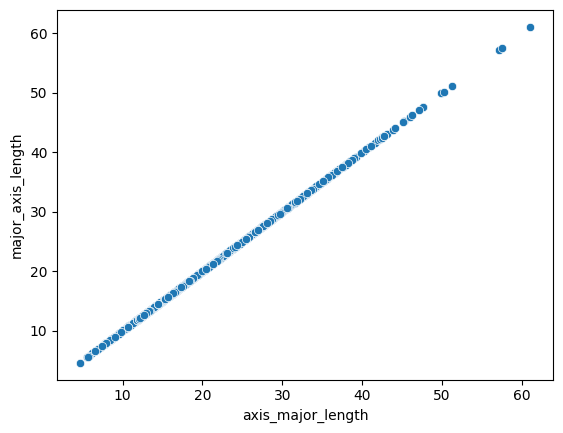

In [13]:
sns.scatterplot(x="axis_major_length", y="major_axis_length", data=merged_mibi)
plt.show()

Looks like the values are identical, so the merge was successful.

## 5.5 Plot the Centroids (2D)

Now that all the data is pulled and merged, we can move on to working with some spatial coordinates. Here we will be using the centroid coordinates for this sample to reproduce figure 2D. In addition, we will take a look at some other features the points can be colored by.

In the text, Figure 2D is described as the following:

(D) Representative MIBI image of a DCIS tumor with a nine-color overlay of major cell lineage markers. Inset showing the corresponding H&E image; scale bar: 100 μm. Pt., patient.


To recreate this figure, we first subset the relevant markers based on those shown in the figure along with features such as K10_clusters.
The data table is then pivoted to a longer format and plotted.

In [14]:
# Set figure size
sns.set(rc={'figure.figsize':(10,10)})

# Subset the merged data from earlier
labeled_centroids = merged_mibi[['area','K10_cluster', 'cell_size','celllineage',
                                 'phenotype',"centroid-0",'centroid-1','ECADKRTCD45GLUT1',
                                 'CK7', 'CK5','SMA', 'CD31', 'Tryptase','VIM','CD45', 'Tryptase']]

# Reshape the data into a long format so all the markers can be used as hue groupings
labeled_centroids_melt = labeled_centroids.melt(id_vars=['area','K10_cluster','celllineage',
                                                         'phenotype','cell_size',"centroid-0",
                                                         'centroid-1'])
# Remove markers with 0 expression
filt_labeled_centroids_melt = labeled_centroids_melt[labeled_centroids_melt.value > 0]

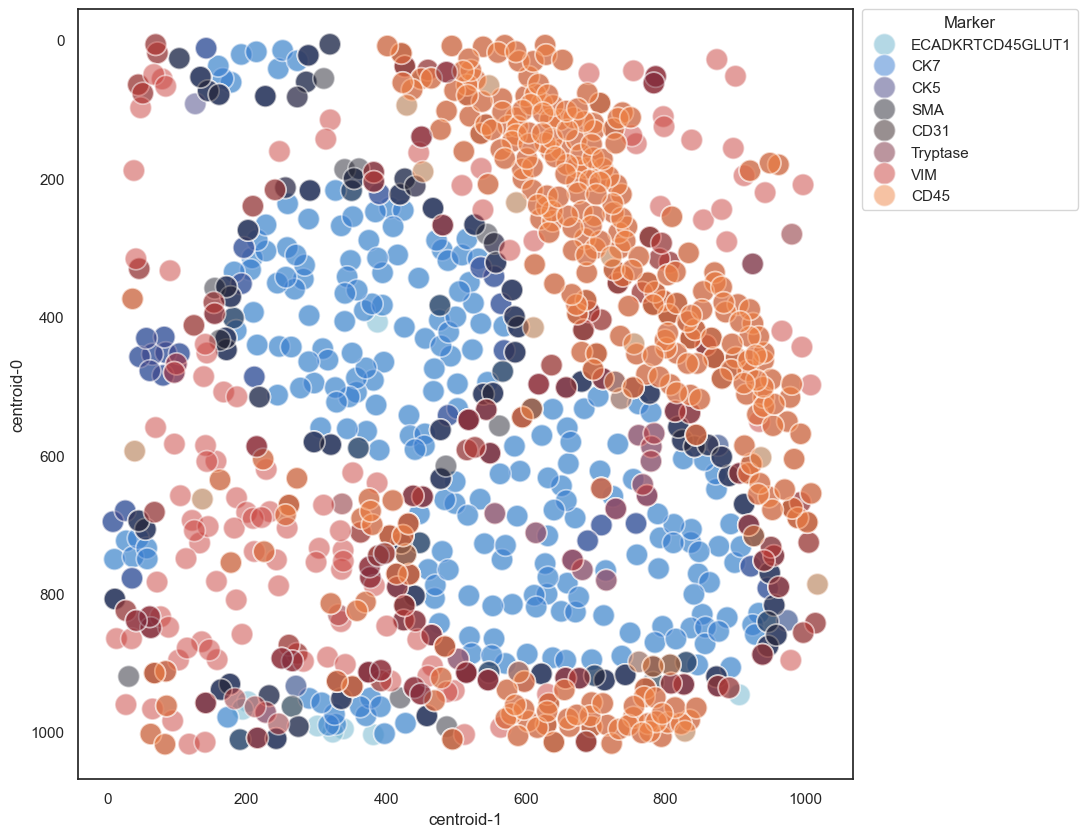

In [22]:
# Set the seaborn theme
sns.set_style("white")

# Let's plot the centroids and color them by marker first:
g = sns.scatterplot(y="centroid-0", x="centroid-1", s=250, hue ='variable',
                    data=filt_labeled_centroids_melt, alpha = 0.5, palette="icefire")
sns.move_legend(g, "upper right", title='Marker', bbox_to_anchor=(1.3, 1.01))
# In this case, we flip the y-axis so it aligns with the figure in the publication
g.invert_yaxis()

Compared to Figure 2D from the paper, the shape and appearance of the cell distribution looks consistent. Here, the marker size was increased for easier viewing. The axes represent the calculated centroid locations from the segmentation data.

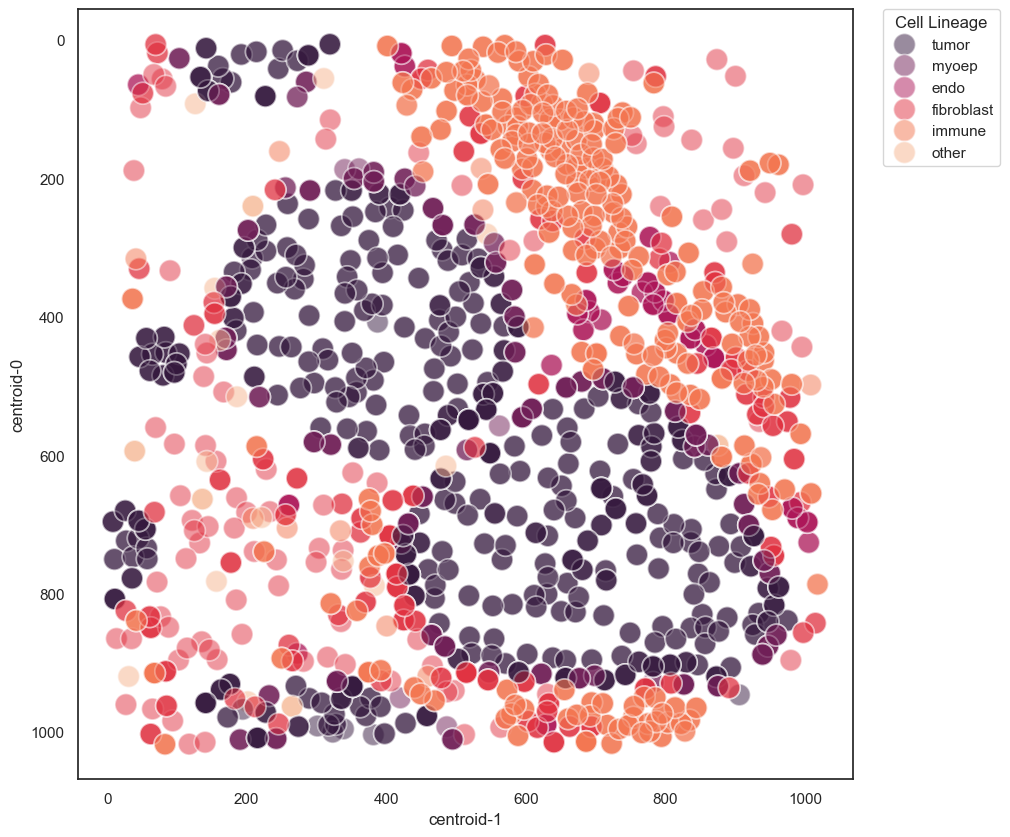

In [21]:
# Next, let's see if coloring by cell lineage changes things
g=sns.scatterplot(y="centroid-0", x="centroid-1", s=250, hue ='celllineage',
                  data=filt_labeled_centroids_melt, alpha = 0.5, palette="rocket")
sns.move_legend(g, "upper right", title='Cell Lineage', bbox_to_anchor=(1.2, 1.01))
g.invert_yaxis()

In the figure above, we can see the cell lineage distributions are consistent with the publication. Tumor markers are localized mainly to tumor cells and so on.

Additionally, we can look at the results of the clustering analysis provided in the level 4 data.

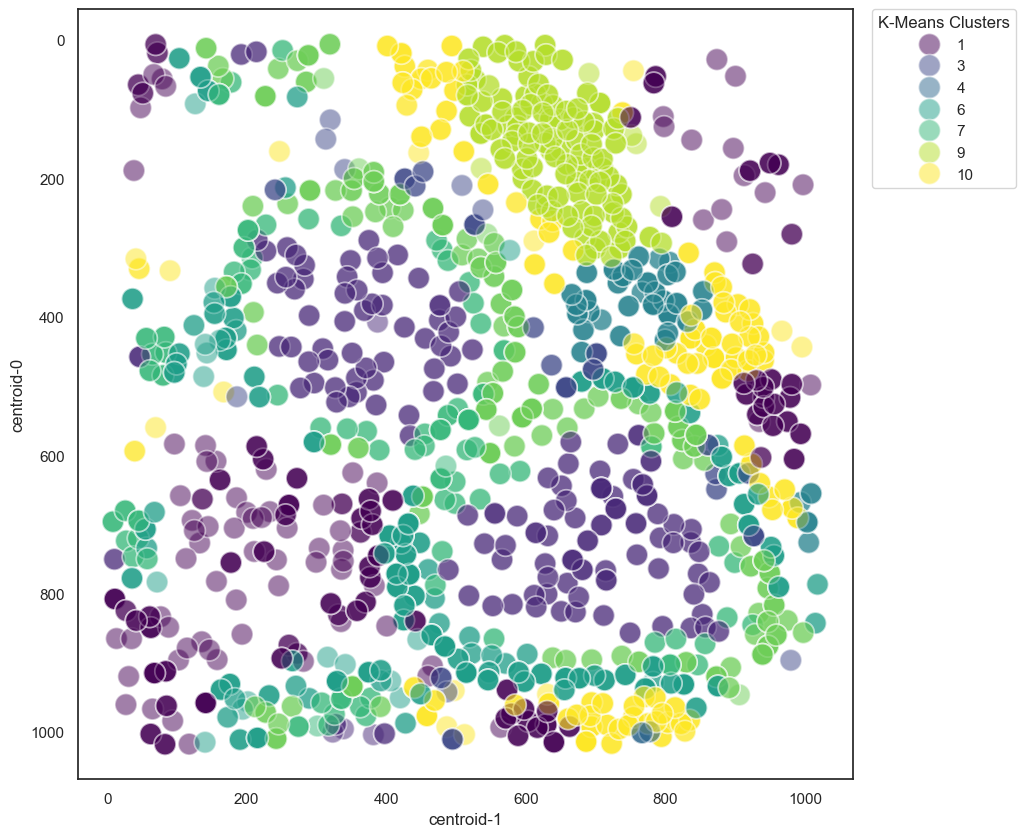

In [19]:
# Plot the clustering data
filt_labeled_centroids_melt.loc[:, 'K10_cluster'] = filt_labeled_centroids_melt['K10_cluster']\
                                                    .astype(int)
g=sns.scatterplot(y="centroid-0", x="centroid-1", s=250, hue ='K10_cluster',
                  data=filt_labeled_centroids_melt, alpha = 0.5, palette="viridis")
sns.move_legend(g, "upper right", title='K-Means Clusters', bbox_to_anchor=(1.22, 1.01))
g.invert_yaxis()

With clustering analysis, we infer the simularity of cells based on their groupings. For example, here the tumor cells are grouped into a singular group (Group 3) which distinguishes them from the surrounding cells in groups 6-9.

## 5.6 Plot Cell Phenotypes (2E)

Lastly, we can use the centroids to recreate Figure 2E.

In the publication the 2E is described as:
(E) A cell phenotype map (CPM) showing cell identity by color, as defined in C, overlaid onto the cell segmentation mask; scale bar: 100 μm.

Since we already have the data shaped and laid out, recreating this figure is as simple as those above. We simply color our centroids by the Cell Phenotype in the plot.

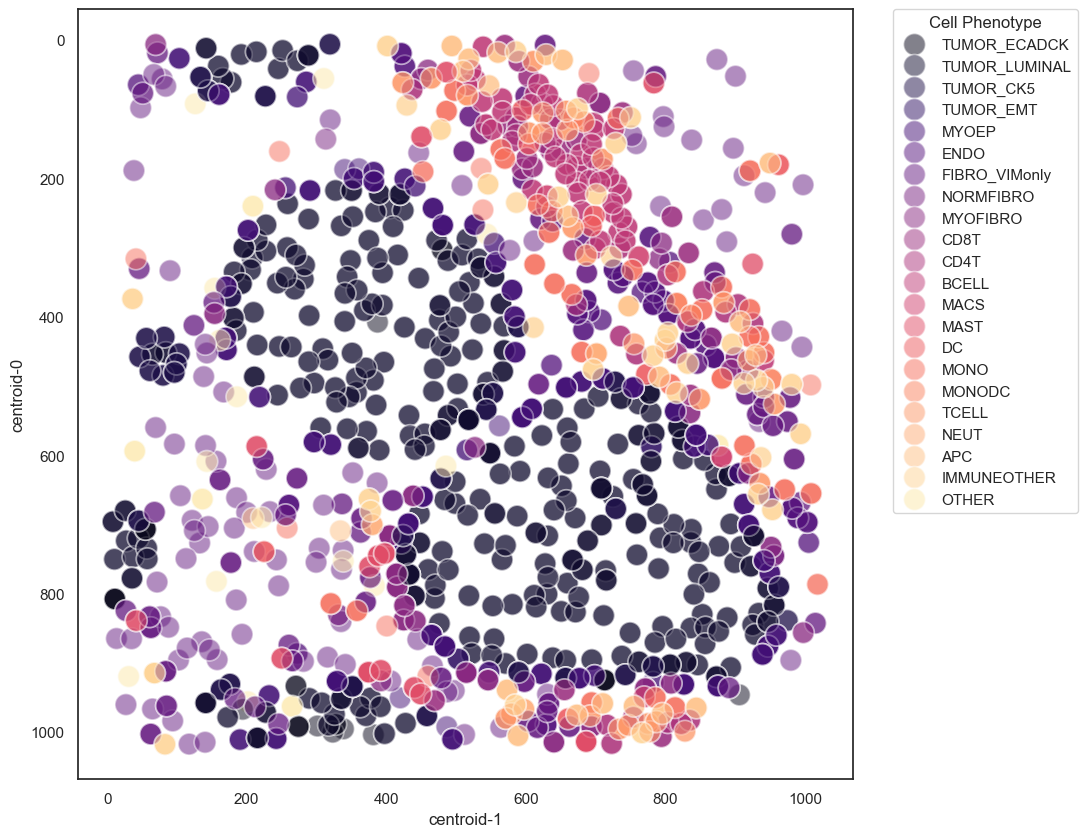

In [20]:
## Figure 2E
g=sns.scatterplot(y="centroid-0", x="centroid-1", s=250, hue ='phenotype',
                  data=filt_labeled_centroids_melt, alpha = 0.5, palette="magma")
sns.move_legend(g, "upper right", title='Cell Phenotype', bbox_to_anchor=(1.3, 1.01))
g.invert_yaxis()

As before, this figure appears consistent with the one shown in the publication.

# 6. Relevant Citations and Links

[Risom T, et al., Transition to invasive breast cancer is associated with progressive changes in the structure and composition of tumor stroma. Cell.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8792442/)

[HTAN Portal](https://humantumoratlas.org/)   


[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)